<a href="https://colab.research.google.com/github/Zuzzi/BDAprojects/blob/master/MyUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### FIRST THING FIRST COMES AUTHENTICATION
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 48.6MB/s 


In [2]:
fileId = drive.CreateFile({'id': '1jqjHB2QYwh7eTEqWEB5QFCcbNNkhOPXA'}) 
fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(fileId['title'], fileId['id']))


fileId1 = drive.CreateFile({'id': '18yJQH7ksJy4QMZ9UCMCQrApuKq93C7jw'}) 
fileId1.GetContentFile(fileId1['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(fileId1['title'], fileId1['id']))




#train
# https://drive.google.com/open?id=1jqjHB2QYwh7eTEqWEB5QFCcbNNkhOPXA
#groundtruth
# https://drive.google.com/open?id=18yJQH7ksJy4QMZ9UCMCQrApuKq93C7jw




Uploaded training_data.zip, id 1jqjHB2QYwh7eTEqWEB5QFCcbNNkhOPXA
Uploaded ground_truth_data.zip, id 18yJQH7ksJy4QMZ9UCMCQrApuKq93C7jw


In [3]:
!unzip ground_truth_data
!unzip training_data

Archive:  ground_truth_data.zip
  inflating: training_sa_crop_pat5-label.nii  
  inflating: training_sa_crop_pat6-label.nii  
  inflating: training_sa_crop_pat7-label.nii  
  inflating: training_sa_crop_pat8-label.nii  
  inflating: training_sa_crop_pat9-label.nii  
  inflating: training_sa_crop_pat0-label.nii  
  inflating: training_sa_crop_pat1-label.nii  
  inflating: training_sa_crop_pat2-label.nii  
  inflating: training_sa_crop_pat3-label.nii  
  inflating: training_sa_crop_pat4-label.nii  
Archive:  training_data.zip
  inflating: training_sa_crop_pat6.nii  
  inflating: training_sa_crop_pat7.nii  
  inflating: training_sa_crop_pat8.nii  
  inflating: training_sa_crop_pat9.nii  
  inflating: training_sa_crop_pat0.nii  
  inflating: training_sa_crop_pat1.nii  
  inflating: training_sa_crop_pat2.nii  
  inflating: training_sa_crop_pat3.nii  
  inflating: training_sa_crop_pat4.nii  
  inflating: training_sa_crop_pat5.nii  


In [4]:
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_prediction
import matplotlib.pyplot as plt_maschera
from google.colab.patches import cv2_imshow
from keras import backend as K
from keras import layers
from keras.layers import Activation
from keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from PIL import Image
from keras.preprocessing.image import load_img
import numpy as np
import nibabel as nib
from google.colab import files
from PIL import Image
import PIL.ImageOps  
from scipy.ndimage import zoom

Using TensorFlow backend.


In [5]:
img_rows = 128
img_cols = 160

array_training = np.zeros((207,128,160))
array_gt = np.zeros((207,128,160))

for x in range (10):
  img_training = nib.load('../content/training_sa_crop_pat%d.nii' % (x))
  img_gt = nib.load('../content/training_sa_crop_pat%d-label.nii' % (x))
  array_img_training = np.array(img_training.dataobj)
  array_img_gt = np.array(img_gt.dataobj)
  array_img_training=np.swapaxes(array_img_training,0,1)
  array_img_gt=np.swapaxes(array_img_gt,0,1)
  print("shape img training %d: " % (x))
  print(array_img_training.shape)
  print("shape img gt %d: " % (x))
  print(array_img_gt.shape)
  
  array_img_training = zoom(array_img_training, (1, 128/array_img_training.shape[1], 160/array_img_training.shape[2]))
  array_img_gt = zoom(array_img_gt, (1, 128/array_img_gt.shape[1], 160/array_img_gt.shape[2]))
  print("NUOVO shape img training %d: " % (x))
  print(array_img_training.shape)
  print("NUOVO shape img gt %d: " % (x))
  print(array_img_gt.shape)
  if (x == 0):
    array_training = array_img_training
    array_gt = array_img_gt
  else :
    array_training = np.concatenate((array_training, array_img_training), axis = 0)
    array_gt = np.concatenate((array_gt, array_img_gt), axis = 0)
    
print("--> shape array training finale concatenato: ")
print(array_training.shape)
print("--> shape array gt finale concatenato: ")
print(array_gt.shape)
  
array_training = array_training.reshape((array_training.shape[0], array_training.shape[1], array_training.shape[2],1))

#preprocessing delle immagini
array_training = array_training.astype('float32')
mean = np.mean(array_training)
std = np.std(array_training)

array_training -= mean
array_training /= std


shape img training 0: 
(207, 127, 151)
shape img gt 0: 
(207, 127, 151)
NUOVO shape img training 0: 
(207, 128, 160)
NUOVO shape img gt 0: 
(207, 128, 160)
shape img training 1: 
(220, 127, 160)
shape img gt 1: 
(220, 127, 160)
NUOVO shape img training 1: 
(220, 128, 160)
NUOVO shape img gt 1: 
(220, 128, 160)
shape img training 2: 
(231, 118, 190)
shape img gt 2: 
(231, 118, 190)
NUOVO shape img training 2: 
(231, 128, 160)
NUOVO shape img gt 2: 
(231, 128, 160)
shape img training 3: 
(175, 150, 148)
shape img gt 3: 
(175, 150, 148)
NUOVO shape img training 3: 
(175, 128, 160)
NUOVO shape img gt 3: 
(175, 128, 160)
shape img training 4: 
(105, 95, 130)
shape img gt 4: 
(105, 95, 130)
NUOVO shape img training 4: 
(105, 128, 160)
NUOVO shape img gt 4: 
(105, 128, 160)
shape img training 5: 
(120, 97, 164)
shape img gt 5: 
(120, 97, 164)
NUOVO shape img training 5: 
(120, 128, 160)
NUOVO shape img gt 5: 
(120, 128, 160)
shape img training 6: 
(230, 150, 170)
shape img gt 6: 
(230, 150, 1

In [0]:
def dice_coef(y_true, y_pred):
    #loss dice_coeff per 3 classi (valori possibili della label 0,1 e 2)
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    Ncl = y_pred.shape[-1]
    w = np.zeros((Ncl,))
    for l in range(0,Ncl): w[l] = np.sum( np.asarray(y_true[:,:,l]==1,np.int8) )
    w = 1/(w**2+0.00001)

    # Compute gen dice coef:
    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2))
    numerator = K.sum(numerator)
    
    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2))
    denominator = K.sum(denominator)
    
    gen_dice_coef = numerator/denominator
    
    return 1-2*gen_dice_coef
   
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
def up_conv_block(input_tensor, kernel_size, filters, stage, block, strides=(1, 1)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    up_conv_name_base = 'up' + str(stage) + block + '_branch'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = UpSampling2D(size=(2, 2), name=up_conv_name_base + '2a')(input_tensor)

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(x)

    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = UpSampling2D(size=(2, 2), name=up_conv_name_base + '1')(input_tensor)
    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(shortcut)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x
  
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


In [0]:
def get_resnet(f=16, bn_axis=3, classes=3):
    input = Input((img_rows, img_cols, 1))
    x = ZeroPadding2D((4, 4))(input)
    
    x = Conv2D(f, (7, 7), strides=(2, 2), name='conv1')(x)

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = conv_block(x, 3, [f, f, f * 2], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [f, f, f * 2], stage=2, block='b')
    x2 = identity_block(x, 3, [f, f, f * 2], stage=2, block='c')

    x = conv_block(x2, 3, [f * 2, f * 2, f * 4], stage=3, block='a')
    x = identity_block(x, 3, [f * 2, f * 2, f * 4], stage=3, block='b')
    x3 = identity_block(x, 3, [f * 2, f * 2, f * 4], stage=3, block='d')

    x = conv_block(x3, 3, [f * 4, f * 4, f * 8], stage=4, block='a')
    x = identity_block(x, 3, [f * 4, f * 4, f * 8], stage=4, block='b')
    x4 = identity_block(x, 3, [f * 4, f * 4, f * 8], stage=4, block='f')

    x = conv_block(x4, 3, [f * 8, f * 8, f * 16], stage=5, block='a')
    x = identity_block(x, 3, [f * 8, f * 8, f * 16], stage=5, block='b')
    x = identity_block(x, 3, [f * 8, f * 8, f * 16], stage=5, block='c')

    x = up_conv_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='a')
    x = identity_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='b')
    x = identity_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='c')
    
    x = concatenate([x, x4], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='a')
    x = identity_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='b')

    x = identity_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='f')
    x = concatenate([x, x3], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='a')
    x = identity_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='b')
    x = identity_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='d')
    x = concatenate([x, x2], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 4, f, f], stage=10, block='a', strides=(1, 1))
    x = identity_block(x, 3, [f * 4, f, f], stage=10, block='b')
    x = identity_block(x, 3, [f * 4, f, f], stage=10, block='c')

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, (3, 3), padding='same', activation='sigmoid', name='convLast')(x)

    model = Model(input, x, name='resnetUnet')

    model.compile(optimizer=Adam( lr=3e-5), loss=dice_coef_loss,
                  metrics=[dice_coef] )
       # model.compile(optimizer=Adam(lr=3e-4), loss=dice_coef_loss,
        #          metrics=[dice_coef, 'accuracy', precision, recall, f1score])

    model.summary()

    return model

In [9]:
#realizza il modello Unet per 3 classi
model = get_resnet(f=16, bn_axis=3, classes=3)

W0628 10:11:50.396104 139830396741504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 10:11:50.429412 139830396741504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 10:11:50.439038 139830396741504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 10:11:50.470467 139830396741504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0628 10:11:50.471264 1398303967

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 160, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 136, 168, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 65, 81, 16)   800         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 65, 81, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
from keras.utils import to_categorical


# suddivisione del dataset in 70% training e 30% test
x_train = array_training[0:1350]
x_test = array_training[1351:1928]

y_train = array_gt[0:1350]
y_test = array_gt[1351:1928]

# one hot encoding con tensorflow per 3 classi
import tensorflow as tf
n_classes = 3 
tensor=tf.one_hot(y_train, n_classes)   

#trasformaiamo il tensor in numpy array
with tf.Session() as sess:
   y_train_ohe=sess.run(tensor)

# alleniamo il modello
results = model.fit(x_train, y_train_ohe, batch_size=16, epochs=3)

Epoch 1/3
1350/1350 [==============================] - 28s 21ms/step - loss: -0.7402 - dice_coef: 0.7402
Epoch 2/3
1350/1350 [==============================] - 9s 7ms/step - loss: -0.8484 - dice_coef: 0.8484
Epoch 3/3
1350/1350 [==============================] - 9s 7ms/step - loss: -0.9041 - dice_coef: 0.9041


In [0]:
import matplotlib.pyplot as plt
# testa il modello
predicted_image = model.predict(x_test, verbose = 0)




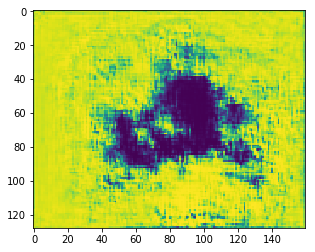

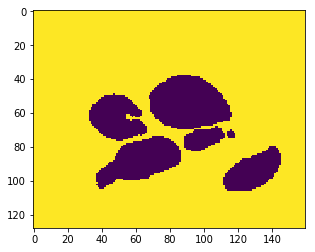

In [12]:
# risultato della predizione, slice 0 con label = 0
image = (predicted_image[0][:, :,0] * 255.).astype(np.uint8)
img = Image.fromarray(image)  
img = PIL.ImageOps.invert(img)
plt_prediction.imshow(img)
plt_prediction.show()


# maschera, slice 0 con label = 0 (prima ne facciamo il one-hot-encoding)
test=tf.one_hot(y_test,3) 

with tf.Session() as sess:
   d=sess.run(test)

image = (d[0][:, :,0] * 255.).astype(np.uint8)
img = Image.fromarray(image)
plt_maschera.imshow(img)
plt_maschera.show()

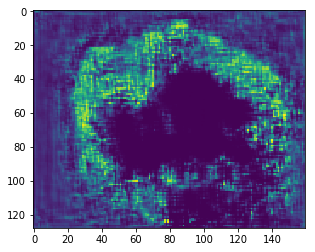

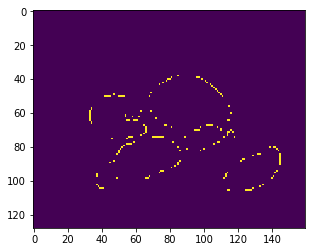

In [13]:
# risultato della predizione, slice 0 con label = 1
image = (predicted_image[0][:, :,1] * 255.).astype(np.uint8)
img = Image.fromarray(image)
img = PIL.ImageOps.invert(img)
plt_prediction.imshow(img)
plt_prediction.show()


# maschera, slice 0 con label = 1 (prima ne facciamo il one-hot-encoding)
test=tf.one_hot(y_test,3) 

with tf.Session() as sess:
   d=sess.run(test)

image = (d[0][:, :,1] * 255.).astype(np.uint8)
img = Image.fromarray(image)
plt_maschera.imshow(img)
plt_maschera.show()

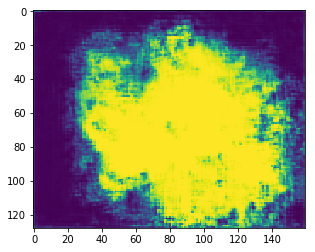

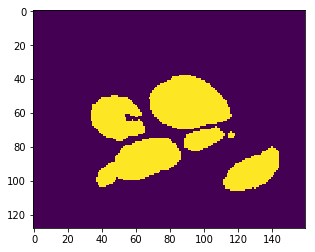

In [14]:
# risultato della predizione, slice 0 con label = 2
image = (predicted_image[0][:, :,2] * 255.).astype(np.uint8)
img = Image.fromarray(image) 
img = PIL.ImageOps.invert(img)
plt_prediction.imshow(img)
plt_prediction.show()


# maschera, slice 0 con label = 2 (prima ne facciamo il one-hot-encoding)
test=tf.one_hot(y_test,3) 

with tf.Session() as sess:
   d=sess.run(test)

image = (d[0][:, :,2] * 255.).astype(np.uint8)
img = Image.fromarray(image)
plt_maschera.imshow(img)
plt_maschera.show()